
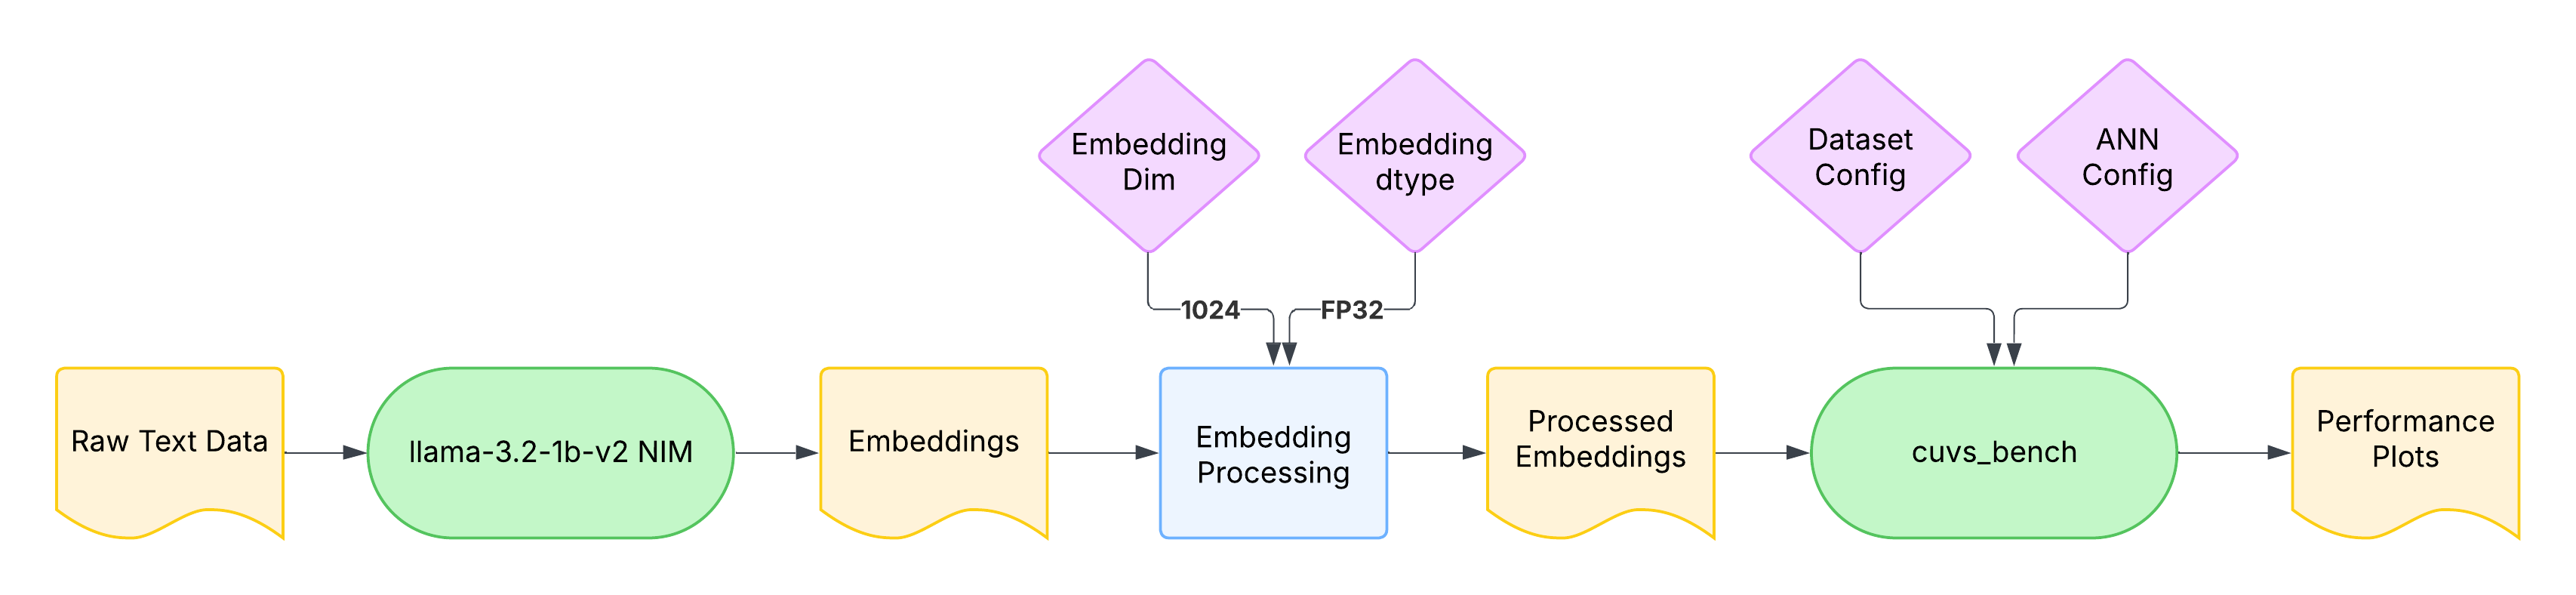


# Index Build and Search Parameter Optimization with NVIDIA cuVS Bench

[NVIDIA cuVS bench](https://docs.rapids.ai/api/cuvs/stable/cuvs_bench/#) is a benchmarking tool with various Approximate Nearest Neighbor (ANN) search algorithms implemented on both CPU and GPU-accelerated hardware. One of the primary use case for cuVS bench is to capture optimal index build parameters which balances search recall against search latency (or throughput) for specific datasets under consideration. Since index building can be performed offline, we can use a high performance cluster to determine optimal build/search parameters and then apply the parameters found to a separate cluster with more limited resources.

## Data Pre-processing
First, the dataset is randomly sampled. It is assumed that the data subset (around 5% of the dataset) is representative of the whole dataset since it can be prohibitively expensive to run exhaustive parameter search against the entire dataset. Then we perform a uniform grid search of index build and search parameters to exhaustively determine the best combination of parameters to use on the entire dataset to achieve a sufficient level of search recall (e.g., 95%). 

Using our vector embedding pipeline, the output is nested set of numpy files with vectors stored in `embedding.npy` files. These files are read into memory, truncated to the desired number of dimensions, and numerically approximated to a lower precision in order to reduce the memory footprint. Quantization (specifically int8) and rescaling can be performed to make better use of the limited numerical range while preserving semantic similarity. Combining these different transformations allow us to store more vectors within a limited amount of memory. It can also enable much greater throughout since fewer dimensions and/or numerical digits are involved.

After pre-processing the vectors, we need to export them in a cuVS bench compatible file format. More details on the data format can be found [here](https://docs.rapids.ai/api/cuvs/nightly/cuvs_bench/datasets). 

## Getting Started
This notebook provides a simplified workflow for preparing the data for cuVS bench. In the next cell, modify `RAW_DATA_PATH`, and `DATASET_NAME` to correspond to system specifications. Update `DIM` and `PRECISION` to the desired data dimension and precision, respectively. 

Provided in `/datasets/miracl_ranges_int8_raw.npy` are the int8 vector ranges for the original 2048 dimensional dataset computed from around 106M vectors. This ensures scaling is representative of the entire dataset. Since values have been precomputed for the miracl dataset, we can set `get_vector_ranges=False` and apply the precomputed values.

Once the cuVS bench compatible files (`base.*`, `query.*`, `config.yaml`) has been created in `./datasets/DATASET_NAME`, run `cuvs-bench_run_build_and_search.ipynb` to load the data into cuVS bench for build/search parameter optimization

In [1]:
# Path to the folder containing raw, unprocessed numpy embedding files (.npy format)
RAW_DATA_PATH = f"/raid/embeddings/miracl-data/fp32-2048dim/miracl-106M"

# Specify the name of the dataset you are working with (used for organizing processed data)
DATASET_NAME = "miracl-fp32-1024d-1M"

# Please fill in the number of vectors to sample from the original dataset
# These will be included in the *base dataset* 
NUM_SAMPLES = 1_000_000

# Please fill in the number of vectors to use as queries
# These will be included in the *query dataset*
NUM_QUERIES = 10_000

# Please fill in the desired number of dimension and precision
# Choose from 384, 512, 768, 1024, 2048 to preserve 
DIM = 1024        
PRECISION = "float32"  # Data type used to store embeddings (choose from "float32", "float16", "int32", "uint8","int8")

# Compute and export vector ranges (min/max) for dataset. Should be ran at least once,
# ideally for most of dataset (e.g., NUM_SAMPLES=large number). This is used in scaling
# numerical ranges for int8 quantization. Takes ~15min for 100M fp32, 2048d vectors.
get_vector_ranges = False

# Only in-memory processing implemented
process_chunks_in_mem = True

# Number of embedding.npy to load simultaneously.
# Choose large values to load >1M vectors at once.
num_files_per_batch = 1000

## Run Data Pre-processing Pipeline

In [2]:
%%time
import os
import glob
import numpy as np
import struct
import pandas as pd
import threading
import subprocess
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sentence_transformers.quantization import quantize_embeddings

# Path to the folder where processed dataset files will be stored, organized under the dataset name
PROCESSED_DATA_PATH = f"datasets/{DATASET_NAME}"
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
print(f"Directory created at: {PROCESSED_DATA_PATH}")

# Sample data within directory
raw_data_folder = f"{RAW_DATA_PATH}"
processed_data_folder = f"{PROCESSED_DATA_PATH}"

# Get list of embedding files
embedding_files = glob.glob(f'{raw_data_folder}/**/embedding.npy', recursive=True)
num_files = len(embedding_files)

embedding_files_batch = [embedding_files[i:i+num_files_per_batch] for i in 
                         range(0, len(embedding_files), num_files_per_batch)]

# Extract dataset metrics
row_count_store = []
vector_min_store = []
vector_max_store = []

for batch in embedding_files_batch:
    batch_data = [np.load(f, mmap_mode='r') for f in batch]
    
    num_rows = [d.shape[0] for d in batch_data]
    row_count_store.append(num_rows)
    
    if get_vector_ranges:
        min_vals = np.vstack([d.min(axis=0) for d in batch_data])
        max_vals = np.vstack([d.max(axis=0) for d in batch_data])
        
        # Save min/max values for use as scaling factor
        vector_min_store.append(min_vals)
        vector_max_store.append(max_vals)

if get_vector_ranges:
    # Aggregate vector ranges
    vector_min = np.vstack(vector_min_store).min(axis=0)
    vector_max = np.vstack(vector_max_store).max(axis=0)
    vector_ranges = np.vstack([vector_min, vector_max])
    
    # Save vector_ranges to disk. It's a fixed range for entire dataset.
    np.save(f'datasets/miracl_ranges_{PRECISION}_raw.npy', vector_ranges)

    # Truncate vector ranges to desired dimensions for use
    vector_ranges = vector_ranges

# Create dataframe with file metadata
toc_df = pd.DataFrame({'filename': embedding_files, 'num_rows': np.concatenate(row_count_store)})
total_rows = toc_df['num_rows'].sum()
print('Total number of vectors in dataset:', total_rows)

/home/nvidia/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Directory created at: datasets/miracl-fp32-1024d-1M
Total number of vectors in dataset: 106332152
CPU times: user 18.7 s, sys: 1.09 s, total: 19.8 s
Wall time: 5.8 s


In [3]:
query_set_ratio = NUM_QUERIES/total_rows
sample_set_ratio = NUM_SAMPLES/total_rows

# Coalesce each batch into a single dataset before sampling. 
base_embeddings_store = []
query_embeddings_store = []
batch_num = 0

for batch in tqdm(embedding_files_batch):
    # Load data and truncate dimensions
    batch_data = [np.load(file, mmap_mode='r')[:, :DIM] for file in batch]
    batch_data = np.concatenate(batch_data)
    
    # Split data into two mutually exclusive sets
    X_train, X_test, _, _ = train_test_split(batch_data, range(len(batch_data)), train_size=sample_set_ratio, 
                                                    test_size=query_set_ratio, random_state=42)

    # int8 quantization as needed
    if PRECISION == 'int8':
        # Load pre-computed vector ranges. Truncate to desired dimensions.
        vector_ranges = np.load(f'datasets/miracl_ranges_{PRECISION}_raw.npy')[:, :DIM]
        
        # See https://sbert.net/examples/sentence_transformer/applications/embedding-quantization/README.html#scalar-quantization-in-sentence-transformers
        base_embeddings = quantize_embeddings(
            X_train,
            precision=PRECISION,
            ranges=vector_ranges
        )
        
        query_embeddings = quantize_embeddings(
            X_test,
            precision=PRECISION,
            ranges=vector_ranges
        )
    elif PRECISION in ['float16', 'float32']:
        base_embeddings = X_train
        query_embeddings = X_test
    else:
        raise ValueError(f'Precision {PRECISION} not implemented.')

    if process_chunks_in_mem:
        # Store results in memory
        base_embeddings_store.append(base_embeddings)
        query_embeddings_store.append(query_embeddings)
    else:
        batch_num += 1
        
        # TODO: Save intermediate results to disk so larger datasets can be handled.
    

# Accumulate results into a single numpy array
base_embeddings_store = np.concatenate(base_embeddings_store)
query_embeddings_store = np.concatenate(query_embeddings_store)

# Around 250GB peak RAM utilization for 80M vectors with fp32, 384dim.
# Need to implement incremental writes to disk to reduce mem requirements.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [04:50<00:00, 26.39s/it]


In [4]:
def save_bin(base_path, embeddings, precision):
    """
    Save embedding vectors to a binary file with file type inferred from embeddings' dtype.

    Parameters:
    - base_path: Path with extension (e.g. "/output/base.u8bin")
    - embeddings: numpy array, each row is a vector. Dtype determines file suffix.
    """

    num_vectors, num_dimensions = embeddings.shape

    with open(base_path, 'wb') as f:
        # Write header (number of vectors, dimensions)
        f.write(struct.pack('<II', num_vectors, num_dimensions))
        embeddings.tofile(f)

DTYPE_TO_SUFFIX = {
    "float32": 'fbin',
    "float16": 'f16bin',
    "int32":   'ibin',
    "uint8":   'u8bin',
    "int8":    'i8bin',
}

# Write cuVS bench compatible data files to disk
suffix = DTYPE_TO_SUFFIX[PRECISION]
base_output=f"base.{suffix}"
query_output=f"query.{suffix}"

base_embeddings_path=f"{PROCESSED_DATA_PATH}/{base_output}"
query_embeddings_path=f"{PROCESSED_DATA_PATH}/{query_output}"

save_bin(base_embeddings_path, base_embeddings_store, precision=PRECISION)
save_bin(query_embeddings_path, query_embeddings_store, precision=PRECISION)

In [5]:
# Create cuVS bench data config file
config_template = """- name: {dataset_name}
  dims: {dim}
  base_file: {dataset_name}/base.{suffix}
  query_file: {dataset_name}/query.{suffix}
  groundtruth_neighbors_file: {dataset_name}/groundtruth.neighbors.ibin
  distance: euclidean
"""

# Substitute variables
config_content = config_template.format(dataset_name=DATASET_NAME, dim=DIM, suffix=suffix)

# Create directory and write file 
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True) 
with open(f"{PROCESSED_DATA_PATH}/config.yaml", 'w') as f: 
    f.write(config_content) 

print(f"Dataset: {DATASET_NAME}")
print(f"Path: {PROCESSED_DATA_PATH}")
print("Config content:")
print(config_content)

Dataset: miracl-fp32-1024d-1M
Path: datasets/miracl-fp32-1024d-1M
Config content:
- name: miracl-fp32-1024d-1M
  dims: 1024
  base_file: miracl-fp32-1024d-1M/base.fbin
  query_file: miracl-fp32-1024d-1M/query.fbin
  groundtruth_neighbors_file: miracl-fp32-1024d-1M/groundtruth.neighbors.ibin
  distance: euclidean

